# Board of Estimates Tabulator  
The purpose of this software tool is to use the pdf files that store the minutes of Baltimore's Board of Estimates to create a small database with linked tables for entities that could possibly include:

- __meetings__
    - one entity per BoE meeting
    - primary key is the date
- __agreements__
    - primary key is BAN plus the partner organization's name
    - features include: date, dollar amount, BAN, description
- __prequalifications__
- __contractors__ 
- __personnel__
- __reclassifications__

## Setup
### Import packages  
**We may want to break visualization code into a separate notebook

In [1]:
from datetime import datetime
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from pathlib import Path
import time 
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from utils import *
from bike_rack.parse_utils import parse_pdf

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

### Define directories and urls
We'll also create the `pdf_files` directory if it doesn't exist already.

In [2]:
base_url = "https://comptroller.baltimorecity.gov/"
minutes_url = base_url + "boe/meetings/minutes"

root = Path.cwd()
pdf_dir = root / "pdf_files"

try:
    pdf_dir.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print("The pdf directory already exists.")
else:
    print("The pdf directory has been created.")

The pdf directory already exists.


### Store PDFs to local directory  
The following code downloads all the .pdf files with minutes from the Board of Estimates and saves them in your local version of this repository. 

The code will skip this time-consuming step if it detects files within the `pdf_files` directory.

The tricky part of this is getting a correct date for every file. Some files have a typo somewhere in html, so the functions `store_boe_pdfs()` and  `parse_long_dates()` are built to handle these errors. We may see new types of errors appear in the future, however.

In [3]:
# set to true if you'll be repeatedly running store_boe_pdfs()
testing_mode = False

if testing_mode:
    if pdf_dir:
        del_dir_contents(pdf_dir)
if is_empty(pdf_dir):
    store_boe_pdfs(base_url, minutes_url)
else: 
    print("Files already exist in the pdf directory.")

Files already exist in the pdf directory.


## Process and prepare sample data
### Parse only a few sample pdfs
While we're still in development mode, we can save some time by only parsing a few pdfs instead of all 500+ 

In [4]:
# specifies the paths for a couple sample pdfs
meeting1_path = Path("pdf_files/2013/2013_11_20.pdf")
meeting2_path = Path("pdf_files/2010/2010_03_17.pdf")

# uses parse_pdf() to instantiate the Minutes class for each meeting
meeting1 = parse_pdf(meeting1_path)
meeting2 = parse_pdf(meeting2_path)

print(meeting1.clean_text[:500])

4680 BOARD OF ESITMATES November 20, 2013 MINUTES REGULAR MEETING Honorable Bernard C. "Jack" Young, President Honorable Stephanie Rawlings-Blake, Mayor - ABSENT Harry Black, Director of Finance Honorable Joan M. Pratt, Comptroller and Secretary George A. Nilson, City Solicitor Alfred H. Foxx, Director of Public Works David E. Ralph, Deputy City Solicitor Rudolph S. Chow, Deputy Director of Public Works Bernice H. Taylor, Deputy Comptroller and Clerk Pursuant to Article VI, Section 1(c) of the r


## Process and prepare data
### Create a Pandas dataframe with full texts  
Now that we have the .pdf files we need, we're ready to read them and store their text in a Pandas dataframe. 

This should take about one minute for each year of data.

In [9]:
text_df_raw = store_pdf_text_to_df(pdf_dir)

Wrote 527 rows to the table of minutes.


### View a sample of the stored text

In [10]:
text_df_raw.sample(6, random_state=444)

,date,page_number,minutes
376,2020-10-14,3960,"3960\n \nBOARD OF ESTIMATES\n \n \nOCTOBER 14,..."
289,2010-07-14,2341,2341 BOARD OF ESTIMATES ...
315,2019-02-06,584,"584\n \nBOARD OF \nESTIMATES\n \nFEBRUARY 06, ..."
0,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI..."
285,2010-09-29,3357,3357 BOARD OF ESTIMATES ...
187,2009-08-19,3094,3094 BOARD OF ESTIMATES ...


### Replace erroneous characters and consolidate white spaces
Not sure if decision to transform all multiple white spaces to a single white space will work for the long term because we may need to use multiple spaces to detect certain fields.

I hope we won't need to do that, though. Currently we're consolidating all multiple white spaces into just one white space.

In [11]:
text_df = text_df_raw.copy()

text_df['text'] = text_df['minutes'].apply(replace_chars)

In [12]:
# view a sample of the transformed text
print(text_df['text'][0][0:500])

4680  BOARD OF ESITMATES  November 20' 2013 MINUTES  REGULAR MEETING  Honorable Bernard C. "Jack" Young' President Honorable Stephanie Rawlings-Blake' Mayor - ABSENT Harry Black' Director of Finance Honorable Joan M. Pratt' Comptroller and Secretary George A. Nilson' City Solicitor 
Alfred H. Foxx' Director of Public Works David E. Ralph' Deputy City Solicitor Rudolph S. Chow' Deputy Director of Public Works 
Bernice H. Taylor' Deputy Comptroller and Clerk 
  Pursuant to Article VI' Section 1(c)


In [33]:
def add_fiscal_year(df):
    df = df.copy()
    df["calendar_year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    c = pd.to_numeric(df["calendar_year"])
    df["fiscal_year"] = np.where(df["month"] >= 7, c + 1, c)
    df["fiscal_year"] = (pd.to_datetime(df["fiscal_year"], format="%Y")).dt.year
    return df

text_df['date'] = pd.to_datetime(text_df['date'])
text_df = add_fiscal_year(text_df)

text_df.head(3)

,date,page_number,minutes,text,calendar_year,month,fiscal_year
0,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU...",2013,11,2014
1,2013-01-30,280,"280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUT...","280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUTE...",2013,1,2013
2,2013-08-14,3045,"3045 BOARD OF ESTIMATES August 14, 2013 MINUT...","3045 BOARD OF ESTIMATES August 14, 2013 MINUTE...",2013,8,2014


### Store the date of meeting as the index

In [34]:
text_df = text_df.set_index('date', drop=False)
text_df['word_count'] = text_df['text'].apply(lambda x: len(x.split()))

text_df.head(3)

,date,page_number,minutes,text,calendar_year,month,fiscal_year,word_count
date,,,,,,,,
2013-11-20,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU...",2013,11,2014,22448
2013-01-30,2013-01-30,280,"280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUT...","280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUTE...",2013,1,2013,11455
2013-08-14,2013-08-14,3045,"3045 BOARD OF ESTIMATES August 14, 2013 MINUT...","3045 BOARD OF ESTIMATES August 14, 2013 MINUTE...",2013,8,2014,42186


## Compute and visualize a few basic features
Let's see how two very basic features change over time:

- Meetings per year
- Total word count of all meetings per year

### Filter to show only complete fiscal years

In [46]:
meetings_per_year = text_df[['minutes', 'fiscal_year']].groupby('fiscal_year').count().reset_index()

cond_1 = meetings_per_year['fiscal_year'] < 2021
cond_2 = meetings_per_year['fiscal_year'] > 2009

meetings_per_year = meetings_per_year[cond_1 & cond_2]
meetings_per_year.head(3)

,fiscal_year,minutes
1,2010,44
2,2011,46
3,2012,46


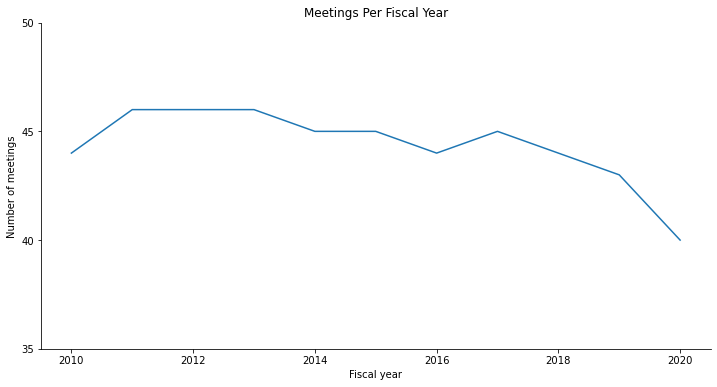

In [50]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12,6))
ax = sns.lineplot(x='fiscal_year', y='minutes', data=meetings_per_year)

ax.set(title="Meetings Per Fiscal Year", ylabel="Number of meetings", xlabel = "Fiscal year", ylim=(35, 50))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))

sns.despine()

In [52]:
words_per_year = text_df.groupby('fiscal_year')['word_count'].sum().reset_index()

words_per_year = words_per_year[cond_1 & cond_2]

words_per_year.head(3)

,fiscal_year,word_count
1,2010,788800
2,2011,788521
3,2012,903824


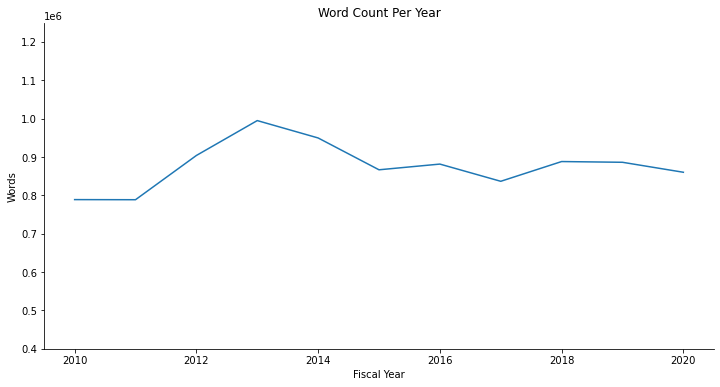

In [57]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(x='fiscal_year', y='word_count', data=words_per_year)

ax.set(title="Word Count Per Year", ylabel="Words", xlabel="Fiscal Year", ylim=(400_000, 1_250_000))

sns.despine()

## Tabulate data
### Create empty dataframes

In [60]:
def create_dateframes():
    meetings_df = pd.DataFrame(
        columns=["date", "president", "mayor", "no_of_protests", "no_of_settlements",]
    )
    agreements_df = pd.DataFrame(
        columns=["date", "department", "contractor", "account_number", "agreement",]
    )
    accounts_df = pd.DataFrame(
        columns=["date", "account_number",]
    )
    
    return meetings_df, agreements_df, accounts_df

agreements_df, meetings_df, accounts_df = create_dateframes()

### Test out account regex

In [84]:
account_lookup = r"\d{4}-\d{6}-\d{4}-\d{6}-\d{6}"
sample_text = text_df['text']
sample_text = 'blah blah 5000-585919-1191-719000-603096 blah blah'
list_of_accounts = list(re.findall(re.compile(account_lookup), sample_text))

len(list_of_accounts)

1

### List all account numbers for each meeting

In [85]:
def find_all_accounts(row):
    account_lookup = r"\d{4}-\d{6}-\d{4}-\d{6}-\d{6}"
    meeting_date = row['date']
    list_of_accounts = list(re.findall(re.compile(account_lookup), row['text']))
    return list_of_accounts
    

text_df['accounts'] = text_df.apply(find_all_accounts, axis=1)
text_df.head()

,date,page_number,minutes,text,accounts
0,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU...","[4000-496313-3573-591219-603051, 2089-208914-5..."
1,2013-01-30,280,"280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUT...","280 BOARD OF ESTIMATES JANUARY 30, 2013 MINUTE...","[9905-922004-9188-900000-709047, 4000-807513-6..."
2,2013-08-14,3045,"3045 BOARD OF ESTIMATES August 14, 2013 MINUT...","3045 BOARD OF ESTIMATES August 14, 2013 MINUTE...","[2032-000000-1330-158400-605008, 2044-000000-1..."
3,2013-08-28,3346,"3346 BOARD OF ESTIMATES AUGUST 28, 2013 MINUT...","3346 BOARD OF ESTIMATES AUGUST 28, 2013 MINUTE...","[5000-598014-2252-688000-600000, 5000-598314-2..."
4,2013-06-05,2018,"2018 BOARD OF ESTIMATES JUNE 05, 2013 MINUTES...","2018 BOARD OF ESTIMATES JUNE 05, 2013 MINUTES ...","[2036-000000-1752-175200-603070, 1001-000000-1..."


### Unnest account numbers
This takes all the account numbers that were stored together in a list and makes each one its own row.

In [86]:
def unnesting(df, explode):
    idx = df.index.repeat(df[explode[0]].str.len())
    df1 = pd.concat(
        [pd.DataFrame({x: np.concatenate(df[x].values)}) for x in explode], axis=1
    )
    df1.index = idx
    return df1.join(df.drop(explode, 1), how="left")

        
accounts_df = unnesting(text_df,['accounts'])

accounts_df.head(3)

,accounts,date,page_number,minutes,text
0,4000-496313-3573-591219-603051,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU..."
0,2089-208914-5930-437923-603051,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU..."
0,2089-208914-5930-426526-603051,2013-11-20,4680,"4680 BOARD OF ESITMATES November 20, 2013 MI...","4680 BOARD OF ESITMATES November 20, 2013 MINU..."


### Count the account numbers mentioned per year
Not sure if this is the right approach to dropping duplicate account numbers, but for now I'm dropping anything where the same account is mentioned in the same meeting.

In [70]:
accounts_df = accounts_df.drop_duplicates(subset=['fiscal_year', 'accounts'], keep='last')

cond_1 = accounts_df['fiscal_year'] > 2009
cond_2 = accounts_df['fiscal_year'] < 2021
accounts_df = accounts_df[cond_1 & cond_2]
accounts_per_year = accounts_df.groupby('fiscal_year')['accounts'].count().reset_index()

accounts_per_year.head()

,fiscal_year,accounts
0,2010,1669
1,2011,1515
2,2012,1486
3,2013,1509
4,2014,1182


### Hmm. That's weird.
Looks like accounts dropped off quickly in 2015.

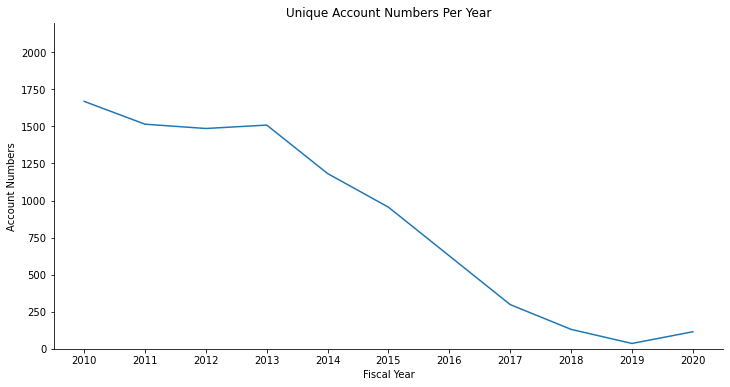

In [75]:
plt.figure(figsize=(12,6))
ax = sns.lineplot(x='fiscal_year', y='accounts', data=accounts_per_year)

ax.set(title="Unique Account Numbers Per Year", ylabel="Account Numbers", xlabel="Fiscal Year", ylim=(0, 2200))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
sns.despine()

In [20]:
#^.+?(?=(\s–|-\s).*Agreements)
# department_lookup = r"^.+?(?=–|-.*Agreements)"
# department_lookup = r"(?<=MINUTES).+?(?=(\s–|-\s).*)"
# department_lookup = r"(?<=MINUTES).+(?=(\s-\s))"